# Rough Fit for Proof of Concept

In [1]:
import numpy as np

pixels = np.array([ (721, 2022), # pixels
                    (1068, 1934),
                    (984, 1804),
                    (1112, 40),
                  ])
physical = np.array([ (179.155, 2), # mm, slit number
                      (133.901, 6),
                      (144.962, 12),
                      (129.033, 92)
                    ])


# Pad the data with ones, so that our transformation can do translations too
n = pixels.shape[0]
pad = lambda x: np.hstack([x, np.ones((x.shape[0], 1))])
unpad = lambda x: x[:,:-1]
X = pad(pixels)
Y = pad(physical)

# Solve the least squares problem X * A = Y
# to find our transformation matrix A
A, res, rank, s = np.linalg.lstsq(X, Y)

transform = lambda x: unpad(np.dot(pad(x), A))

print("Target:")
print(physical)
print("Result:")
print(transform(pixels))
print("Max error:", np.abs(physical - transform(pixels)).max())
A[np.abs(A) < 1e-10] = 0  # set really small values to zero
print('Transformation Matrix')
print(A)

Target:
[[ 179.155    2.   ]
 [ 133.901    6.   ]
 [ 144.962   12.   ]
 [ 129.033   92.   ]]
Result:
[[ 179.16102716    2.01634855]
 [ 133.91694512    6.04325081]
 [ 144.93810778   11.93519282]
 [ 129.03491995   92.00520782]]
Max error: 0.0648071795272
Transformation Matrix
[[ -1.30501561e-01   9.53563140e-05   0.00000000e+00]
 [ -4.54088456e-04  -4.53842457e-02   0.00000000e+00]
 [  2.74170820e+02   9.37145414e+01   1.00000000e+00]]


In [2]:
Ainv, res, rank, s = np.linalg.lstsq(Y, X)

reverse = lambda x: unpad(np.dot(pad(x), Ainv))

print("Target:")
print(pixels)
print("Result:")
print(reverse(physical))
print("Max error:", np.abs(pixels - reverse(physical)).max())
Ainv[np.abs(Ainv) < 1e-10] = 0  # set really small values to zero
print('Reverse Transformation Matrix')
print(Ainv)

Target:
[[ 721 2022]
 [1068 1934]
 [ 984 1804]
 [1112   40]]
Result:
[[  721.04512804  2022.36190124]
 [ 1068.11857426  1934.95089813]
 [  983.82176362  1802.57064561]
 [ 1112.01453407    40.11655501]]
Max error: 1.42935438825
Reverse Transformation Matrix
[[ -7.66267614e+00  -1.60085615e-02   0.00000000e+00]
 [  7.66750274e-02  -2.20338636e+01   0.00000000e+00]
 [  2.09369852e+03   2.06929764e+03   1.00000000e+00]]


In [3]:
reverse(np.array([[179.155, 2]]))

array([[  721.04512804,  2022.36190124]])

In [5]:
transform(np.array([[721, 2022]]))

array([[ 179.16102716,    2.01634855]])

# Use Mask With No Long Slits for Full Fit

In [51]:
import numpy as np
from scipy import ndimage
from astropy.io import fits
from astropy.modeling import models, fitting

import matplotlib as mpl
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
mask_image_file = '/Users/jwalawender/MOSFIRE_Test_Data/20170501/m170502_0092.fits'
hdul = fits.open(mask_image_file, 'readonly')
hdul[0].data.shape

(2048, 2048)

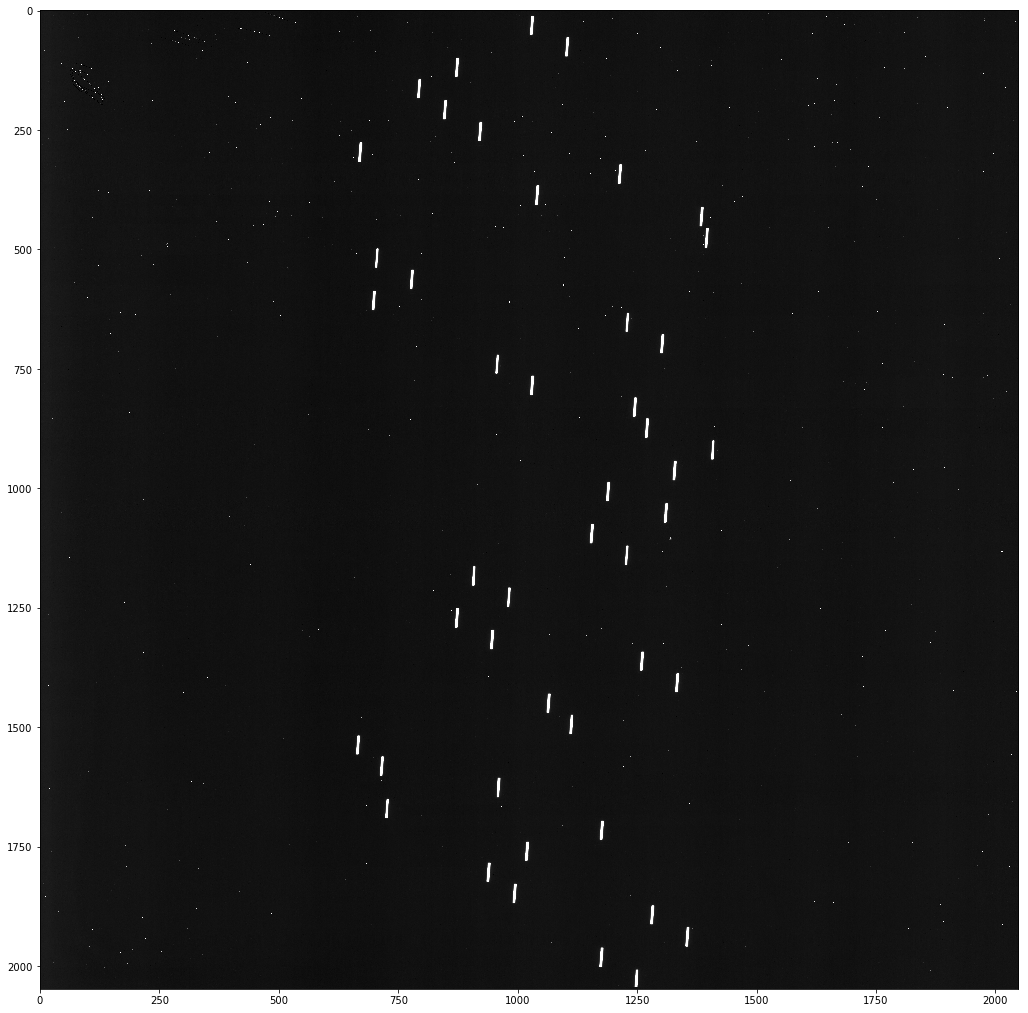

In [12]:
plt.figure(figsize=(18,18))
plt.imshow(hdul[0].data, vmin=-200, vmax=2000)
plt.show()

In [301]:
slitpos = {46: (1030, 30),
           45: (1103, 75),
           44: (880, 120),
           43: (800, 163),
           42: (847, 210),
           41: (920, 257),
           40: (671, 302),
           39: (1215, 345),
           38: (1040, 388),
           37: (1384, 432),
           36: (1396, 479),
           35: (707, 520),
           34: (780, 566),
           33: (700, 610),
           32: (1229, 654),
           31: (1302, 701),
           30: (958, 742),
           29: (1030, 788),
           28: (1244, 832),
           27: (1270, 876),
           26: (1407, 923),
           25: (1328, 966),
           24: (1188, 1010),
           23: (1310, 1054),
           22: (1155, 1098),
           21: (1230, 1144),
           20: (908, 1188),
           19: (980, 1232),
           18: (873, 1276),
           17: (946, 1317),
           16: (1260, 1364),
           15: (1335, 1410),
           14: (1066, 1454),
           13: (1112, 1498),
           12: (666, 1541),
           11: (715, 1585),
           10: (960, 1629),
           9: (727, 1673),
           8: (1177, 1717),
           7: (1019, 1760),
           6: (937, 1807),
           5: (992, 1851),
           4: (1282, 1895),
           3: (1355, 1942),
           2: (1174, 1986),
          }

## Determine position of an individual slit

In [323]:
filtersize = 5
medimage = ndimage.median_filter(hdul[0].data, size=(1, filtersize)) # median X pixels only (preserve Y structure)
header = hdul[0].header

def analyze_slit(slit, medimage, header, plot=True):
    delta = 28
    x0 = slitpos[slit][0]
    y0 = slitpos[slit][1]
    grady = np.gradient(medimage[y0-delta:y0+delta,x0-delta:x0+delta], axis=0)
    gradx = np.gradient(medimage[y0-delta:y0+delta,x0-delta:x0+delta], axis=1)

    if plot:
        plt.figure(figsize=(12,4))
        plt.subplot(1,4,1)
        plt.imshow(hdul[0].data[y0-delta:y0+delta,x0-delta:x0+delta], vmin=-200, vmax=2000)
        plt.subplot(1,4,2)
        plt.imshow(medimage[y0-delta:y0+delta,x0-delta:x0+delta], vmin=-200, vmax=2000)
        plt.subplot(1,4,3)
        plt.imshow(grady, vmin=-2000, vmax=2000)
        plt.subplot(1,4,4)
        plt.imshow(gradx, vmin=-2000, vmax=2000)
        plt.show()
    vertical_profile = np.sum(grady, axis=1)
    horizontal_profile = np.sum(gradx, axis=0)
    
    # Fit horizontal profile (X position of slit)
    fit_g = fitting.LevMarLSQFitter()
    amp1_est = horizontal_profile[horizontal_profile == min(horizontal_profile)]
    mean1_est = np.argmin(horizontal_profile)
    g_init1 = models.Gaussian1D(amplitude=amp1_est, mean=mean1_est, stddev=2.)
    g_init1.amplitude.max = 0
    amp2_est = horizontal_profile[horizontal_profile == max(horizontal_profile)]
    mean2_est = np.argmax(horizontal_profile)
    g_init2 = models.Gaussian1D(amplitude=amp2_est, mean=mean2_est, stddev=2.)
    g_init2.amplitude.min = 0
    gx1 = fit_g(g_init1, range(0,2*delta), horizontal_profile)
    gx2 = fit_g(g_init2, range(0,2*delta), horizontal_profile)

    # Check Validity of Fit
    if abs(gx1.stddev.value) < 3 and abs(gx2.stddev.value) < 3\
       and gx2.amplitude.value > 100 and gx1.amplitude.value < -100\
       and gx2.mean.value < gx1.mean.value:
        dx1 = gx1.mean.value
        dx2 = gx2.mean.value
    else:
        dx1 = 0
        dx2 = 0


    # Fit vertical profile (Y position of slit)
    fit_g = fitting.LevMarLSQFitter()
    amp1_est = vertical_profile[vertical_profile == max(vertical_profile)]
    mean1_est = np.argmax(vertical_profile)
    g_init1 = models.Gaussian1D(amplitude=amp1_est, mean=mean1_est, stddev=2.)
    g_init1.amplitude.min = 0
    amp2_est = vertical_profile[vertical_profile == min(vertical_profile)]
    mean2_est = np.argmin(vertical_profile)
    g_init2 = models.Gaussian1D(amplitude=amp2_est, mean=mean2_est, stddev=2.)
    g_init2.amplitude.max = 0
    gy1 = fit_g(g_init1, range(0,2*delta), vertical_profile)
    gy2 = fit_g(g_init2, range(0,2*delta), vertical_profile)

    # Check Validity of Fit
    if abs(gy1.stddev.value) < 3 and abs(gy2.stddev.value) < 3\
       and gy1.amplitude.value > 100 and gy2.amplitude.value < -100\
       and gy1.mean.value < gy2.mean.value:
        dy1 = gy1.mean.value
        dy2 = gy2.mean.value
    else:
        dy1 = 0
        dy2 = 0
    
    if plot:
        plt.figure(figsize=(12,5))
        plt.subplot(2,1,1)
        plt.plot(range(0,2*delta), horizontal_profile, 'k-', drawstyle='steps-mid')
        plt.plot(range(0,2*delta), [gx1(x)+gx2(x) for x in range(0,2*delta)], 'g-')
        plt.xlim(0,2*delta)
        plt.xlabel('X pixel')
        plt.subplot(2,1,2)
        plt.plot(range(0,2*delta), vertical_profile, 'k-', drawstyle='steps-mid')
        plt.plot(range(0,2*delta), [gy1(y)+gy2(y) for y in range(0,2*delta)], 'g-')
        plt.xlabel('Y pixel')

        plt.show()

    bar1 = slit*2-1
    bar2 = slit*2
    mm1 = float(header['B{:02d}POS'.format(bar1)])
    mm2 = float(header['B{:02d}POS'.format(bar2)])
    x1 = x0+dx1-delta
    x2 = x0+dx2-delta
    y = y0+(dy1+dy2)/2.-delta
    if abs(y-y0) < 20 and abs(x1-x0) < 20:
        pass
    else:
        print("{:2d}: Large Shift! ({:4.0f} {:4.0f})".format(
              slit, dx1-delta, dx2-delta))
    
    return [(mm2, bar2), (x2, y), (mm1, bar1), (x1, y)]

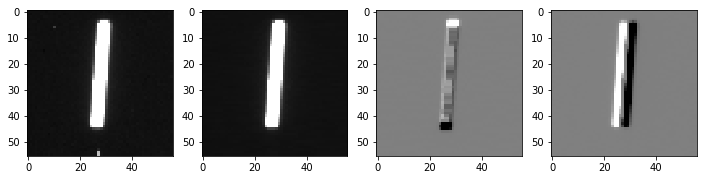

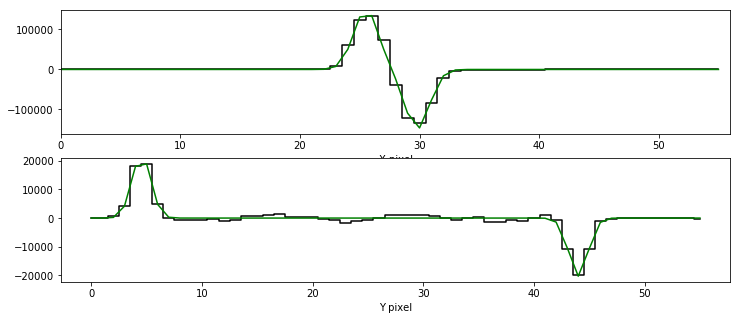

[(180.272, 22),
 (712.5287834914659, 1581.2712766110319),
 (179.765, 21),
 (716.80585127180609, 1581.2712766110319)]

In [324]:
analyze_slit(11, medimage, hdul[0].header, plot=True)

# Now iterate over all slits

In [325]:
pixels = []
physical = []
for slit in slitpos.keys():
    physical_b, pixels_b, physical_a, pixels_a = analyze_slit(slit, medimage, hdul[0].header, plot=False)
    physical.append(physical_b)
    pixels.append(pixels_b)
    physical.append(physical_a)
    pixels.append(pixels_a)

In [326]:
pixels

[(1026.6847023205248, 31.815757489924671),
 (1031.1293065907989, 31.815757489924671),
 (1100.0527926274958, 76.568051304306408),
 (1104.4723170387663, 76.568051304306408),
 (869.79921202733158, 119.71402079180322),
 (874.17468615739256, 119.71402079180322),
 (790.04504261037619, 163.97941699869187),
 (794.38269316256697, 163.97941699869187),
 (844.76764696920873, 208.45498973235158),
 (849.06840834451555, 208.45498973235158),
 (918.16119587182891, 253.46863795483193),
 (922.57167115281891, 253.46863795483193),
 (667.1708458173706, 296.83477802171569),
 (671.58750566149126, 296.83477802171569),
 (1210.6743343816352, 342.85304935109269),
 (1215.1047501727178, 342.85304935109269),
 (1037.1504738673596, 386.56200191364559),
 (1041.5376839155629, 386.56200191364559),
 (1380.9733624348846, 431.75478066748974),
 (1385.3923546613969, 431.75478066748974),
 (1392.3137244788115, 476.40898670973735),
 (1396.5838727543558, 476.40898670973735),
 (701.99737614209846, 518.12290417047029),
 (706.319725

In [327]:
physical

[(139.917, 92),
 (139.41, 91),
 (130.322, 90),
 (129.815, 89),
 (160.334, 88),
 (159.827, 87),
 (170.738, 86),
 (170.231, 85),
 (163.579, 84),
 (163.072, 83),
 (153.983, 82),
 (153.476, 81),
 (186.718, 80),
 (186.211, 79),
 (115.773, 78),
 (115.266, 77),
 (138.413, 76),
 (137.906, 75),
 (93.508, 74),
 (93.001, 73),
 (92.021, 72),
 (91.514, 71),
 (182.097, 70),
 (181.59, 69),
 (172.502, 68),
 (171.995, 67),
 (182.905, 66),
 (182.398, 65),
 (113.665, 64),
 (113.158, 63),
 (104.069, 62),
 (103.562, 61),
 (149.161, 60),
 (148.654, 59),
 (139.566, 58),
 (139.059, 57),
 (111.528, 56),
 (111.021, 55),
 (108.22, 54),
 (107.713, 53),
 (90.189, 52),
 (89.681, 51),
 (100.593, 50),
 (100.086, 49),
 (118.731, 48),
 (118.223, 47),
 (102.94, 46),
 (102.432, 45),
 (123.212, 44),
 (122.704, 43),
 (113.615, 42),
 (113.108, 41),
 (155.354, 40),
 (154.847, 39),
 (145.759, 38),
 (145.251, 37),
 (159.887, 36),
 (159.38, 35),
 (150.292, 34),
 (149.785, 33),
 (109.338, 32),
 (108.83, 31),
 (99.742, 30),
 (99.